This notebook automatically segments objects in images using SAM. It resizes large images, generates masks on GPU if available, saves them, and displays previews for quick inspection

In [7]:
# ---------------- SETUP ----------------
%pip install --upgrade pip setuptools wheel
%pip install git+https://github.com/facebookresearch/segment-anything.git
%pip install opencv-python pillow matplotlib tqdm
%pip install "numpy<2" --force-reinstall

import urllib.request
import os
from tqdm import tqdm

class DownloadProgressBar(tqdm):
    def update_to(self, blocks=1, block_size=1, total_size=None):
        if total_size is not None:
            self.total = total_size
        self.update(blocks * block_size - self.n)

sam_checkpoint = "sam_vit_h.pth"
if not os.path.exists(sam_checkpoint):
    url = "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth"
    with DownloadProgressBar(unit='B', unit_scale=True, miniters=1, desc=sam_checkpoint) as t:
        urllib.request.urlretrieve(url, filename=sam_checkpoint, reporthook=t.update_to)
    print(f"Downloaded {sam_checkpoint}")

Note: you may need to restart the kernel to use updated packages.
  Cloning https://github.com/facebookresearch/segment-anything.git to /private/var/folders/zg/9_3xyygn04z7rrmh7940xlxr0000gn/T/pip-req-build-3nt_dyzt
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /private/var/folders/zg/9_3xyygn04z7rrmh7940xlxr0000gn/T/pip-req-build-3nt_dyzt
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Note: you may need to restart the kernel to use updated packages.
  Using cached numpy-2.2.6-cp310-cp310-macosx_14_0_arm64.whl.metadata (62 kB)
Using cached numpy-2.2.6-cp310-cp310-macosx_14_0_arm64.whl (5.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully 

sam_vit_h.pth: 2.56GB [06:12, 6.89MB/s]                               

Downloaded sam_vit_h.pth


In [8]:
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator

In [9]:
def resize_image(image, max_size):
    w, h = image.size
    if max(w, h) > max_size:
        scale = max_size / max(w, h)
        new_size = (int(w * scale), int(h * scale))
        image = image.resize(new_size)
        return image, new_size
    return image, (w, h)

def generate_and_save_mask(image_np, filename, output_folder):
    masks = mask_generator.generate(image_np)
    mask_canvas = np.zeros(image_np.shape[:2], dtype=np.uint8)
    for i, mask in enumerate(masks, start=1):
        mask_canvas[mask["segmentation"]] = i
    out_path = os.path.join(output_folder, filename.rsplit(".",1)[0] + "_mask.png")
    Image.fromarray(mask_canvas).save(out_path)
    return mask_canvas, out_path

def show_preview(image_np, mask_canvas, filename):
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(image_np)
    plt.title(f"Original: {filename}")
    plt.axis("off")
    plt.subplot(1,2,2)
    plt.imshow(mask_canvas, cmap='tab20')
    plt.title("SAM Masks")
    plt.axis("off")
    plt.show()

In [11]:
# ---------------- SETTINGS ----------------
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

model_type = "vit_h"               
max_size = 512                     
input_folder = "dataset/images"
output_folder = "dataset/masks"
os.makedirs(output_folder, exist_ok=True)

Using device: cpu


In [13]:
# ---------------- INIT SAM ----------------
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device)
mask_generator = SamAutomaticMaskGenerator(sam)
print("SAM initialized successfully!")

SAM initialized successfully!


Saved mask: dataset/masks/000152_mask.png


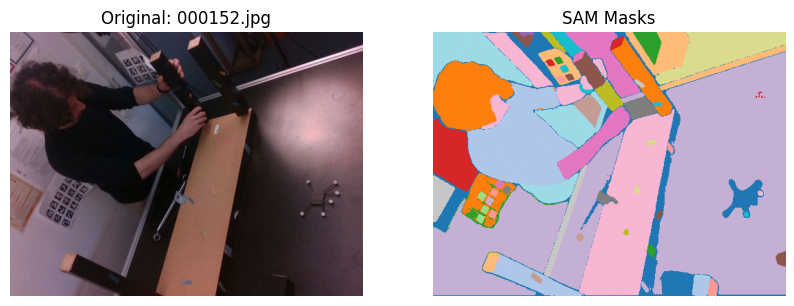

KeyboardInterrupt: 

In [14]:
for filename in os.listdir(input_folder):
    if not filename.lower().endswith((".png", ".jpg", ".jpeg")):
        continue

    img_path = os.path.join(input_folder, filename)
    image = Image.open(img_path).convert("RGB")
    image, new_size = resize_image(image, max_size)
    if new_size != image.size:
        print(f"Resized {filename} to {new_size}")

    image_np = np.array(image)
    mask_canvas, out_path = generate_and_save_mask(image_np, filename, output_folder)
    print("Saved mask:", out_path)
    show_preview(image_np, mask_canvas, filename)